<a href="https://colab.research.google.com/github/cedamusk/Astrophysics/blob/main/PINNs_Implementation_for_Planetary_motion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install torch numpy matplotlib seaborn

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
#from IPython.display import HTML
import seaborn as sns

In [23]:
torch.manual_seed(42)
np.random.seed(42)

In [24]:
class PINN(nn.Module):
  def __init__(self, hidden_size=50):
    super().__init__()
    self.network=nn.Sequential(
        nn.Linear(1, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, hidden_size),
        nn.Tanh(),
        nn.Linear(hidden_size, 2)

    )

  def forward(self, t):
    output=self.network(t)
    print(f"Shape of network output: {output.shape}")
    return output

  def compute_derivatives(self, t):
    t.requires_grad_(True)
    xy = self.forward(t)
    print(f"Shape of xy: {xy.shape}")  # Debugging line

    # Compute first derivative for each output dimension
    dxy_dt = []
    for i in range(xy.shape[1]):  # Loop over output dimensions (x and y)
        grad_outputs = torch.zeros_like(xy)
        grad_outputs[:, i] = 1.0  # Set gradient for the current dimension
        dxy_dt_i = torch.autograd.grad(
            xy, t,
            grad_outputs=grad_outputs,
            create_graph=True,
        )[0]
        dxy_dt.append(dxy_dt_i)

    # Stack the gradients to form a tensor of shape [100, 2]
    dxy_dt = torch.cat(dxy_dt, dim=1)
    print(f"Shape of dxy_dt: {dxy_dt.shape}")  # Debugging line

    # Compute second derivative for each output dimension
    d2xy_dt2 = []
    for i in range(dxy_dt.shape[1]):  # Loop over output dimensions (x and y)
        grad_outputs = torch.zeros_like(dxy_dt)
        grad_outputs[:, i] = 1.0  # Set gradient for the current dimension
        d2xy_dt2_i = torch.autograd.grad(
            dxy_dt, t,
            grad_outputs=grad_outputs,
            create_graph=True,
        )[0]
        d2xy_dt2.append(d2xy_dt2_i)

    # Stack the gradients to form a tensor of shape [100, 2]
    d2xy_dt2 = torch.cat(d2xy_dt2, dim=1)
    print(f"Shape of d2xy_dt2: {d2xy_dt2.shape}")  # Debugging line

    return xy, dxy_dt, d2xy_dt2


  @staticmethod
  def generate_orbital_data(n_points=100, noise_level=0.01):
    t=np.linspace(0, 10, n_points)

    r=1.0
    omega=2*np.pi/5

    x=r*np.cos(omega*t)
    y=r*np.sin(omega*t)

    x+=noise_level*np.random.randn(n_points)
    y+=noise_level*np.random.randn(n_points)

    return t, x, y

  def physics_loss(self, t):
    xy, dxy_dt, d2xy_dt2=self.compute_derivatives(t)
    print(f"Shape of xy in physics_loss: {xy.shape}")
    print(f"Shape of d2xy_dt2 in physics_loss: {d2xy_dt2.shape}")

    k=4*np.pi**2

    r=torch.sqrt(xy[:, 0]**2 +(xy[:, 1]**2)+(xy[:, 1]**2 if xy.shape[1]> 1 else 0))

    residual_x=d2xy_dt2[:, 0]+ k*xy[:, 0]/ (r**3)
    residual_y=(d2xy_dt2[:, 1]+ k*xy[:, 1]/ (r**3) if xy.shape[1]> 1 else 0)

    return torch.mean(residual_x**2 + residual_y**2)

  def train_pinn(self, t_data, xy_data, n_epochs=500):
    optimizer=torch.optim.Adam(self.parameters(), lr=0.001)

    t_torch=torch.FloatTensor(t_data).reshape(-1, 1)
    print(f"Shape of t_torch: {t_torch.shape}")
    xy_torch=torch.FloatTensor(xy_data)

    losses=[]
    for epoch in range(n_epochs):
      optimizer.zero_grad()

      xy_pred=self(t_torch)
      data_loss=torch.mean((xy_pred-xy_torch)**2)

      phys_loss=self.physics_loss(t_torch)

      total_loss=data_loss+0.1*phys_loss

      total_loss.backward()
      optimizer.step()

      losses.append([total_loss.item(), data_loss.item(), phys_loss.item()])

      if (epoch+1)%500==0:
        print(f'Epoch [{epoch+1}/{n_epochs}],'
              f'Loss: {total_loss.item():.4f},'
              f'Data Loss:{data_loss.item():.4f},'
              f'Physics Loss:{phys_loss.item():.4f}')

    return np.array(losses)

  def create_animation(self, t_data, xy_data):
    self.eval()
    with torch.no_grad():
      t_torch=torch.FloatTensor(t_data).reshape(-1, 1)
      xy_pred=self(t_torch).numpy()

    fig=plt.figure(figsize=(12, 6))

    ax1=fig.add_subplot(121)
    ax1.set_aspect('equal')
    ax1.set_xlabel('X Position (AU)')
    ax1.set_ylabel('Y Position (AU)')
    ax1.set_title('Orbital Trajectory')

    ax2=fig.add_subplot(122)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Position')
    ax2.set_title('Position vs Time')

    margin=0.1
    max_range=max(
        np.max(np.abs(xy_data[:, 0])),
        np.max(np.abs(xy_data[:, 1])),
        np.max(np.abs(xy_pred[:, 0])),
        np.max(np.abs(xy_pred[:, 1]))
    )

    ax1.set_xlim(-max_range*(1+margin), max_range*(1+margin))
    ax1.set_ylim(-max_range*(1+margin), max_range*(1+margin))

    trajectory_data, =ax1.plot([], [], 'b.', label='Data', alpha=0.5)
    trajectory_pred, = ax1.plot([], [], 'r-', label='PINN Prediction')
    current_pos_data, =ax1.plot([], [], 'bo', markersize=10)
    current_pos_pred, =ax1.plot([], [], 'ro', markersize=10)

    time_series_x_data, =ax2.plot([], [], 'b.', label='Data X', alpha=0.5)
    time_series_y_data, =ax2.plot([], [], 'g.', label='Data Y', alpha=0.5)
    time_series_x_pred, =ax2.plot([], [], 'r-', label='PINN X')
    time_series_y_pred, =ax2.plot([], [], 'm-', label='PINN Y')
    current_time_marker, =ax2.plot([], [], 'k|', markersize=10)

    ax1.legend()
    ax2.legend()

    ax1.plot([0], [0], 'y*', markersize=15)

    def animate(frame):
      trajectory_data.set_data(xy_data[:frame, 0], xy_data[:frame, 1])
      trajectory_pred.set_data(xy_pred[:frame, 0], xy_pred[:frame, 1])
      current_pos_data.set_data([xy_data[frame, 0]], [xy_data[frame, 1]])
      current_pos_pred.set_data([xy_pred[frame, 0]], [xy_pred[frame, 1]])

      time_series_x_data.set_data(t_data[:frame], xy_data[:frame, 0])
      time_series_y_data.set_data(t_data[:frame], xy_data[:frame, 1])
      time_series_x_pred.set_data(t_data[:frame], xy_pred[:frame, 0])
      time_series_y_pred.set_data(t_data[:frame], xy_pred[:frame, 1])
      current_time_marker.set_data([t_data[frame], t_data[frame]],
                                   [-max_range, max_range])

      return(trajectory_data, trajectory_pred, current_pos_data, current_pos_pred,
             time_series_x_data, time_series_y_data, time_series_x_pred,
             time_series_y_pred, current_time_marker)

    ax2.set_xlim(min(t_data), max(t_data))
    ax2.set_ylim(-max_range*(1+margin), max_range*(1+margin))

    anim=FuncAnimation(fig, animate, frames=len(t_data),
                       interval=50, blit=True)

    plt.tight_layout()
    return anim


In [25]:
def main():

  pinn_instance=PINN()

  t_data, x_data, y_data=pinn_instance.generate_orbital_data()
  xy_data=np.stack([x_data, y_data], axis=1)

  model=PINN()
  losses=model.train_pinn(t_data, xy_data)

  plt.figure(figsize=(10, 4))
  plt.semilogy(losses[:, 0], label='Total Loss')
  plt.semilogy(losses[:, 1], label='Data Loss')
  plt.semilogy(losses[:, 2], label='Physics Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  anim=model.create_animation(t_data, xy_data)
  plt.show()

Shape of t_torch: torch.Size([100, 1])
Shape of network output: torch.Size([100, 2])
Shape of network output: torch.Size([100, 2])
Shape of xy: torch.Size([100, 2])
Shape of dxy_dt: torch.Size([100, 2])
Shape of d2xy_dt2: torch.Size([100, 2])
Shape of xy in physics_loss: torch.Size([100, 2])
Shape of d2xy_dt2 in physics_loss: torch.Size([100, 2])
Shape of network output: torch.Size([100, 2])
Shape of network output: torch.Size([100, 2])
Shape of xy: torch.Size([100, 2])
Shape of dxy_dt: torch.Size([100, 2])
Shape of d2xy_dt2: torch.Size([100, 2])
Shape of xy in physics_loss: torch.Size([100, 2])
Shape of d2xy_dt2 in physics_loss: torch.Size([100, 2])
Shape of network output: torch.Size([100, 2])
Shape of network output: torch.Size([100, 2])
Shape of xy: torch.Size([100, 2])
Shape of dxy_dt: torch.Size([100, 2])
Shape of d2xy_dt2: torch.Size([100, 2])
Shape of xy in physics_loss: torch.Size([100, 2])
Shape of d2xy_dt2 in physics_loss: torch.Size([100, 2])
Shape of network output: torch.

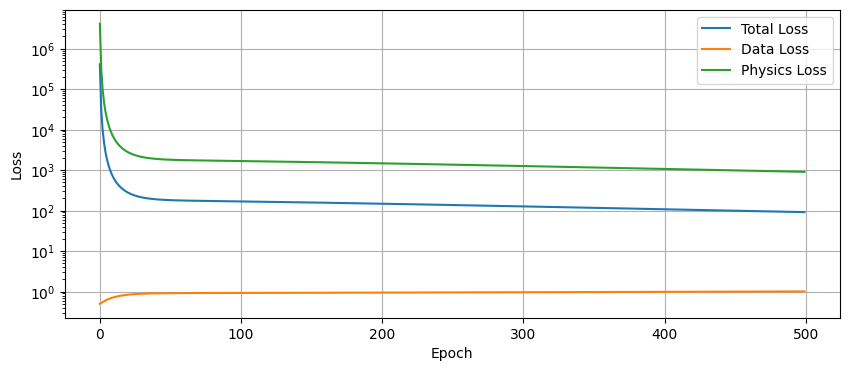

Shape of network output: torch.Size([100, 2])


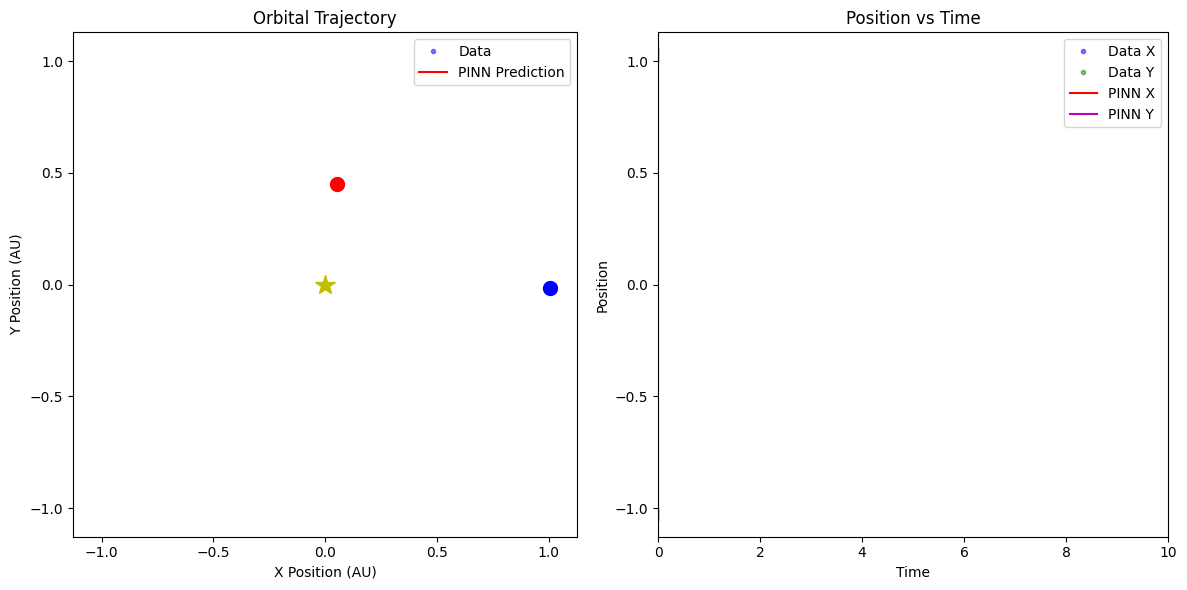

In [26]:
if __name__=="__main__":
  main()